In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ieee-fraud-detection/sample_submission.csv
/kaggle/input/ieee-fraud-detection/test_identity.csv
/kaggle/input/ieee-fraud-detection/train_identity.csv
/kaggle/input/ieee-fraud-detection/test_transaction.csv
/kaggle/input/ieee-fraud-detection/train_transaction.csv


In [2]:
transactions_csv = pd.read_csv("/kaggle/input/ieee-fraud-detection/train_transaction.csv")

In [3]:
!pip uninstall -y scikit-learn imbalanced-learn
!pip install scikit-learn==1.3.2
!pip install imbalanced-learn==0.11.0

Found existing installation: scikit-learn 1.2.2
Uninstalling scikit-learn-1.2.2:
  Successfully uninstalled scikit-learn-1.2.2
Found existing installation: imbalanced-learn 0.13.0
Uninstalling imbalanced-learn-0.13.0:
  Successfully uninstalled imbalanced-learn-0.13.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 57.5 MB/s eta 0:00:0000:010:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
nilearn 0.11.1 requires scikit-learn>=1.4.0, but you have scikit-learn 1.3.2 which is incompatible.
bigframes 1.36.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.6/235.6 kB 5.9 MB/s eta 0:00:00:00:01


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
import shap


X = transactions_csv.drop(columns=["isFraud"])
y = transactions_csv["isFraud"]

user_proxy = (
    X['card1'].astype(str) + '_' +
    X['addr1'].astype(str) + '_' +
    X['P_emaildomain'].astype(str)
)

# First split: 80% train+val, 20% test
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_val_idx, test_idx = next(gss.split(X, y, groups=user_proxy))

X_train_val, X_test = X.iloc[train_val_idx], X.iloc[test_idx]
y_train_val, y_test = y.iloc[train_val_idx], y.iloc[test_idx]
user_proxy_train_val = user_proxy.iloc[train_val_idx]

# Second split: 75% train, 25% validation
gss_val = GroupShuffleSplit(n_splits=1, test_size=0.25, random_state=42)
train_idx, val_idx = next(gss_val.split(X_train_val, y_train_val, groups=user_proxy_train_val))

X_train = X_train_val.iloc[train_idx]
X_val = X_train_val.iloc[val_idx]
y_train = y_train_val.iloc[train_idx]
y_val = y_train_val.iloc[val_idx]

X_train = X_train.drop(columns=["TransactionID"])
X_val = X_val.drop(columns=["TransactionID"])
X_test = X_test.drop(columns=["TransactionID"])

X_train_saved = X_train.copy()
X_val_saved = X_val.copy()
X_test_saved = X_test.copy()

In [6]:
!pip install dagshub mlflow --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.1/260.1 kB 7.0 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.0/29.0 MB 50.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 84.7 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 692.3/692.3 kB 26.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.2/203.2 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.3/74.3 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 3.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. Thi

In [7]:
import dagshub 
import mlflow
dagshub.init(repo_owner='Luka-Surmanidze', repo_name='IEEE-CIS-Fraud-Detection', mlflow=True)

❗❗❗ AUTHORIZATION REQUIRED ❗❗❗

Output()



Open the following link in your browser to authorize the client:
https://dagshub.com/login/oauth/authorize?state=2fb45445-b65f-48ad-9d61-d5fa9a937c8b&client_id=32b60ba385aa7cecf24046d8195a71c07dd345d9657977863b52e7748e0f0f28&middleman_request_id=5b4731ae6823e5908d17ce0c3c658318eb6f67fa2e77cb1b56a6e38e70e7f613




Accessing as Luka-Surmanidze

Initialized MLflow to track repo "Luka-Surmanidze/IEEE-CIS-Fraud-Detection"

Repository Luka-Surmanidze/IEEE-CIS-Fraud-Detection initialized!

In [20]:
# experiment_name = "RandomForest"

In [21]:
# mlflow.set_experiment(experiment_name)

2025/04/27 17:46:14 INFO mlflow.tracking.fluent: Experiment with name 'RandomForest' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/0d4b664c804c45b6b4de5c440e0b4a91', creation_time=1745775974489, experiment_id='2', last_update_time=1745775974489, lifecycle_stage='active', name='RandomForest', tags={}>

In [8]:
import mlflow
logged_model = 'runs:/8afcc60c794a4ecb9cff2954a77f0c32/cleaning_pipeline'

# Load model
cleaning_pipeline = mlflow.sklearn.load_model(logged_model)

In [22]:
# run_name = "RandomForest_cleaningV1"

# mlflow.end_run()
# mlflow.start_run(run_name=run_name)

# mlflow.log_param("Part", "Cleaning")
# mlflow.log_param("Na columns default impute method", "ModeImputing")
# mlflow.log_param("Dropping NA columns default threshold", 0.8)

# mlflow.sklearn.log_model(cleaning_pipeline, "cleaning_pipeline")
# mlflow.end_run()

2025/04/27 17:46:41 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2025/04/27 17:46:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForest_cleaningV1 at: https://dagshub.com/Luka-Surmanidze/IEEE-CIS-Fraud-Detection.mlflow/#/experiments/2/runs/a099e9eed2ee4037b186ac6f13a24f4b
🧪 View experiment at: https://dagshub.com/Luka-Surmanidze/IEEE-CIS-Fraud-Detection.mlflow/#/experiments/2


In [9]:
import mlflow
logged_model = 'runs:/4c47c82df6d146f6894a85253ef84177/engineering_pipeline'

# Load model
engineering_pipeline = mlflow.sklearn.load_model(logged_model)

In [23]:
# run_name = "RandomForest_feature_engineeringV1"

# mlflow.end_run()
# mlflow.start_run(run_name=run_name)

# mlflow.log_param("Part", "Feature Engineering")
# mlflow.log_param("categorical_encoding_technique_1", "woe_encoding")
# mlflow.log_param("categorical_encoding_technique_2", "one_hot_encoding")

# mlflow.log_param("default_threshold_for_one_hot_cols", 3)

# mlflow.sklearn.log_model(engineering_pipeline, "engineering_pipeline")
# mlflow.end_run()

2025/04/27 17:47:08 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2025/04/27 17:47:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForest_feature_engineeringV1 at: https://dagshub.com/Luka-Surmanidze/IEEE-CIS-Fraud-Detection.mlflow/#/experiments/2/runs/39ddac54b5724e9288453777168b967a
🧪 View experiment at: https://dagshub.com/Luka-Surmanidze/IEEE-CIS-Fraud-Detection.mlflow/#/experiments/2


In [10]:
import mlflow
logged_model = 'runs:/98e0a436fecf46fc9003600b909e0542/selection_pipeline'

# Load model
selection_pipeline = mlflow.sklearn.load_model(logged_model)

In [24]:
# run_name = "RandomForest_feature_selectionV1"

# mlflow.end_run()
# mlflow.start_run(run_name=run_name)

# mlflow.log_param("Part", "Feature Selection")
# mlflow.log_param("default_corr_threshold", 0.9)
# mlflow.log_param("highly_correlated_pairs_size", 146)

# mlflow.log_param("low_variance_features_size", 24)

# mlflow.log_param("selection_technique_0", "not_using_selection_at_all(passthrough)")

# mlflow.log_param("selection_technique_1", "finding_highly_correlated_features")

# mlflow.log_param("selection_technique_2", "finding_low_variance_remaining_features")


# mlflow.log_param("default_low_variance_threshold", 0.01)

# mlflow.sklearn.log_model(selection_pipeline, "selection_pipeline")
# mlflow.end_run()

2025/04/27 17:47:36 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2025/04/27 17:47:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForest_feature_selectionV1 at: https://dagshub.com/Luka-Surmanidze/IEEE-CIS-Fraud-Detection.mlflow/#/experiments/2/runs/74d18056e82b4fe5a39d7e48a57b6f98
🧪 View experiment at: https://dagshub.com/Luka-Surmanidze/IEEE-CIS-Fraud-Detection.mlflow/#/experiments/2


In [11]:
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.metrics import roc_auc_score
import numpy as np
from itertools import product

# Assuming you already have X_train, y_train, X_val, y_val, X_test, y_test

# Create a function to test a model with specific parameters
def evaluate_model(pipeline_steps, params, X_train, y_train, X_val, y_val):
    # Create a pipeline with the given parameters
    pipeline = ImbPipeline(pipeline_steps)
    
    # Set parameters
    pipeline.set_params(**params)
    
    # Train the model
    pipeline.fit(X_train, y_train)
    
    # Evaluate on validation set
    y_val_pred_proba = pipeline.predict_proba(X_val)[:, 1]
    val_score = roc_auc_score(y_val, y_val_pred_proba)
    
    return val_score, pipeline


In [12]:
preprocess = [cleaning_pipeline, engineering_pipeline, selection_pipeline]

preprocess_steps = []
for p in preprocess:
    for step in p:
        preprocess_steps.append(step)

preprocess_steps

named_preprocess_steps = [
    ('na_cols_dropper', preprocess_steps[0]), 
    ('na_cols_mode_imputer', preprocess_steps[1]),
    ('CategoricalPreprocessor', preprocess_steps[2]),
    ('cleaner', preprocess_steps[3])
]

In [13]:
from sklearn.ensemble import RandomForestClassifier

pipeline = ImbPipeline([
    *named_preprocess_steps,
    ('sampler', 'passthrough'),
    ('classifier', RandomForestClassifier(random_state=42))
])

pipeline.steps

[('na_cols_dropper',
  ColumnDropper(columns_to_drop=Index(['dist2', 'D6', 'D7', 'D8', 'D9', 'D12', 'D13', 'D14', 'V138', 'V139',
         'V140', 'V141', 'V142', 'V143', 'V144', 'V145', 'V146', 'V147', 'V148',
         'V149', 'V150', 'V151', 'V152', 'V153', 'V154', 'V155', 'V156', 'V157',
         'V158', 'V159', 'V160', 'V161', 'V162', 'V163', 'V164', 'V165', 'V166',
         'V322', 'V323', 'V324', 'V325', 'V326', 'V327', 'V328', 'V329', 'V330',
         'V331', 'V332', 'V333', 'V334', 'V335', 'V336', 'V337', 'V338', 'V339'],
        dtype='object'))),
 ('na_cols_mode_imputer', ModeImputer()),
 ('CategoricalPreprocessor',
  CategoricalPreprocessor(one_hot_columns=['M1', 'M2', 'M3', 'M4', 'M5', 'M6',
                                           'M7', 'M8', 'M9'],
                          woe_columns=['ProductCD', 'card4', 'card6',
                                       'P_emaildomain', 'R_emaildomain'])),
 ('cleaner',
  ColumnDropper(columns_to_drop=['V278', 'V221', 'V132', 'V17', 'V

In [17]:
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler

pipeline_steps = pipeline.steps

print(pipeline_steps)

param_grid = {
    'sampler': [
        # 'passthrough',
        RandomOverSampler(random_state=42, sampling_strategy=0.2)
        # ,
        # RandomUnderSampler(random_state=42, sampling_strategy=0.2)
        # ,
        # SMOTE(random_state=42, sampling_strategy=0.2)
    ],
    'classifier__n_estimators': [
        # 100, 
        200
        # ,
        # 250
    ],             # Number of trees
    'classifier__max_depth': [
        # 10, 
        20],            # Max depth of trees
    'classifier__min_samples_split': [
        5
        # , 10
    ],        # Min samples to split a node
    'classifier__min_samples_leaf': [
        2
        # , 4
    ],          # Min samples in a leaf
    # 'classifier__max_features': ['sqrt', 'log2', None]
}

param_names = list(param_grid.keys())
param_values = list(param_grid.values())
param_combinations = list(product(*param_values))

# Store results
results = []

# Evaluate each combination
print("Starting grid search with predefined validation set...")
for i, combo in enumerate(param_combinations):
    # Create parameter dictionary
    params = {name: value for name, value in zip(param_names, combo)}
    
    # Print progress
    print(f"Evaluating combination {i+1}/{len(param_combinations)}: {params}")
    
    # Evaluate
    val_score, fitted_pipeline = evaluate_model(
        pipeline_steps, params, X_train_saved, y_train, X_val_saved, y_val
    )
    
    # Store results
    results.append({
        'params': params,
        'val_score': val_score,
        'pipeline': fitted_pipeline
    })
    
    print(f"Validation ROC AUC: {val_score:.4f}")
    print("-" * 50)

# Find best model
best_result = max(results, key=lambda x: x['val_score'])
best_params = best_result['params']
best_score = best_result['val_score']
best_model = best_result['pipeline']

print("\nBest parameters:", best_params)
print("Best validation score:", best_score)

[('na_cols_dropper', ColumnDropper(columns_to_drop=Index(['dist2', 'D6', 'D7', 'D8', 'D9', 'D12', 'D13', 'D14', 'V138', 'V139',
       'V140', 'V141', 'V142', 'V143', 'V144', 'V145', 'V146', 'V147', 'V148',
       'V149', 'V150', 'V151', 'V152', 'V153', 'V154', 'V155', 'V156', 'V157',
       'V158', 'V159', 'V160', 'V161', 'V162', 'V163', 'V164', 'V165', 'V166',
       'V322', 'V323', 'V324', 'V325', 'V326', 'V327', 'V328', 'V329', 'V330',
       'V331', 'V332', 'V333', 'V334', 'V335', 'V336', 'V337', 'V338', 'V339'],
      dtype='object'))), ('na_cols_mode_imputer', ModeImputer()), ('CategoricalPreprocessor', CategoricalPreprocessor(one_hot_columns=['M1', 'M2', 'M3', 'M4', 'M5', 'M6',
                                         'M7', 'M8', 'M9'],
                        woe_columns=['ProductCD', 'card4', 'card6',
                                     'P_emaildomain', 'R_emaildomain'])), ('cleaner', ColumnDropper(columns_to_drop=['V278', 'V221', 'V132', 'V17', 'V291', 'V72',
              

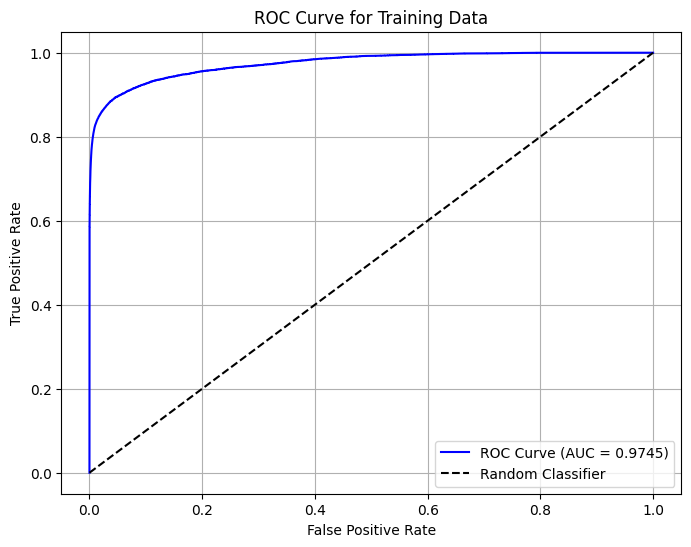

In [18]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt


y_train_proba = best_model.predict_proba(X_train_saved)[:, 1]

# Calculate ROC values using y_train (not y_test)
fpr, tpr, thresholds = roc_curve(y_train, y_train_proba)  # Use y_train here
auc = roc_auc_score(y_train, y_train_proba)  # Use y_train here too

# Plot ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.4f})', color='blue')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Training Data')
plt.legend()
plt.grid(True)
plt.show()

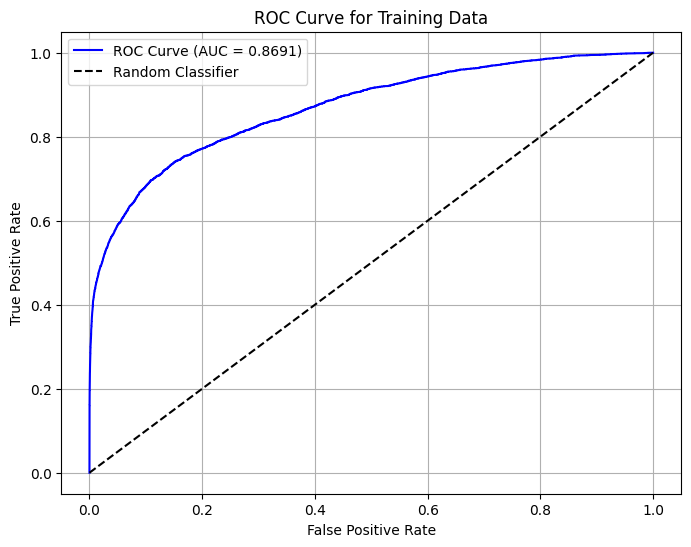

In [19]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Predict probabilities on training data
y_test_proba = best_model.predict_proba(X_test_saved)[:, 1]

# Calculate ROC values using y_train (not y_test)
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)  # Use y_train here
auc = roc_auc_score(y_test, y_test_proba)  # Use y_train here too

# Plot ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.4f})', color='blue')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Training Data')
plt.legend()
plt.grid(True)
plt.show()

In [25]:
# run_name = "RandomForest_trainingV1"

# mlflow.end_run()
# mlflow.start_run(run_name=run_name)

# mlflow.log_param("Part", "Training")
# mlflow.log_param("random_seed", 42)
# mlflow.log_param("best_model_sampler", "RandomOverSampler")

# mlflow.log_param("best_model_n_estimators", 200)
# mlflow.log_param("best_model_max_depth", 20)
# mlflow.log_param("best_model_min_samples_leaf", 2)
# mlflow.log_param("best_model_min_samples_split", 5)

# mlflow.log_param("RandomUnderSamplerStrategy", 0.2)

# mlflow.log_metric("validation_roc_auc_score", 0.8919)

# mlflow.log_metric("train_roc_auc_score", 0.94)

# mlflow.log_metric("test_roc_auc_score", 0.87)

# mlflow.sklearn.log_model(best_model, "RandomForestV1")

# mlflow.end_run()

2025/04/27 17:51:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForest_trainingV1 at: https://dagshub.com/Luka-Surmanidze/IEEE-CIS-Fraud-Detection.mlflow/#/experiments/2/runs/ece0feab11434d5a823410c8865cc69b
🧪 View experiment at: https://dagshub.com/Luka-Surmanidze/IEEE-CIS-Fraud-Detection.mlflow/#/experiments/2
